In [948]:
# Test myanfis model
import myanfis
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [949]:
param = myanfis.fis_parameters(
    n_input=5,
    n_memb=5,
    batch_size=36,
    memb_func='gbellmf',
    optimizer='adam',
    loss='mae',
    n_epochs=150
)

In [950]:
fis = myanfis.ANFIS(n_input=param.n_input,
                    n_memb=param.n_memb,
                    batch_size=param.batch_size,
                    memb_func=param.memb_func,
                    name='myanfis'
                    )

In [951]:
# compile model
fis.model.compile(optimizer=param.optimizer,
                  loss=param.loss)


In [952]:
# Load dataset from CSV file
data = pd.read_csv("data.csv")

In [953]:
data = data.dropna()

In [954]:
# Assuming data has at least 32 * 5 samples for training and 32 * 2 samples for testing
X = data[['Glucose', 'INS', 'BMI', 'DPF', 'Age']].values
Y = data['Outcome'].values.reshape(-1, 1)

In [955]:
# Ensure that the number of samples is a multiple of the batch size
X = X[:len(X) // param.batch_size * param.batch_size]
Y = Y[:len(Y) // param.batch_size * param.batch_size]


In [956]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [957]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [958]:
# fit model
history = fis.fit(X_train, y_train,
                  epochs=param.n_epochs,
                  batch_size=param.batch_size,
                  validation_data=(X_test, y_test))



Epoch 1/150


8/8 [==============================] - 1s 39ms/step - loss: 0.3805 - val_loss: 0.3856
Epoch 2/150
8/8 [==============================] - 0s 8ms/step - loss: 0.3687 - val_loss: 0.3761
Epoch 3/150
8/8 [==============================] - 0s 8ms/step - loss: 0.3595 - val_loss: 0.3672
Epoch 4/150
8/8 [==============================] - 0s 8ms/step - loss: 0.3509 - val_loss: 0.3596
Epoch 5/150
8/8 [==============================] - 0s 8ms/step - loss: 0.3435 - val_loss: 0.3535
Epoch 6/150
8/8 [==============================] - 0s 9ms/step - loss: 0.3374 - val_loss: 0.3483
Epoch 7/150
8/8 [==============================] - 0s 9ms/step - loss: 0.3324 - val_loss: 0.3430
Epoch 8/150
8/8 [==============================] - 0s 9ms/step - loss: 0.3267 - val_loss: 0.3385
Epoch 9/150
8/8 [==============================] - 0s 8ms/step - loss: 0.3222 - val_loss: 0.3340
Epoch 10/150
8/8 [==============================] - 0s 8ms/step - loss: 0.3180 - val_loss: 0.3293
Epoch 11/150
8/8 [======================

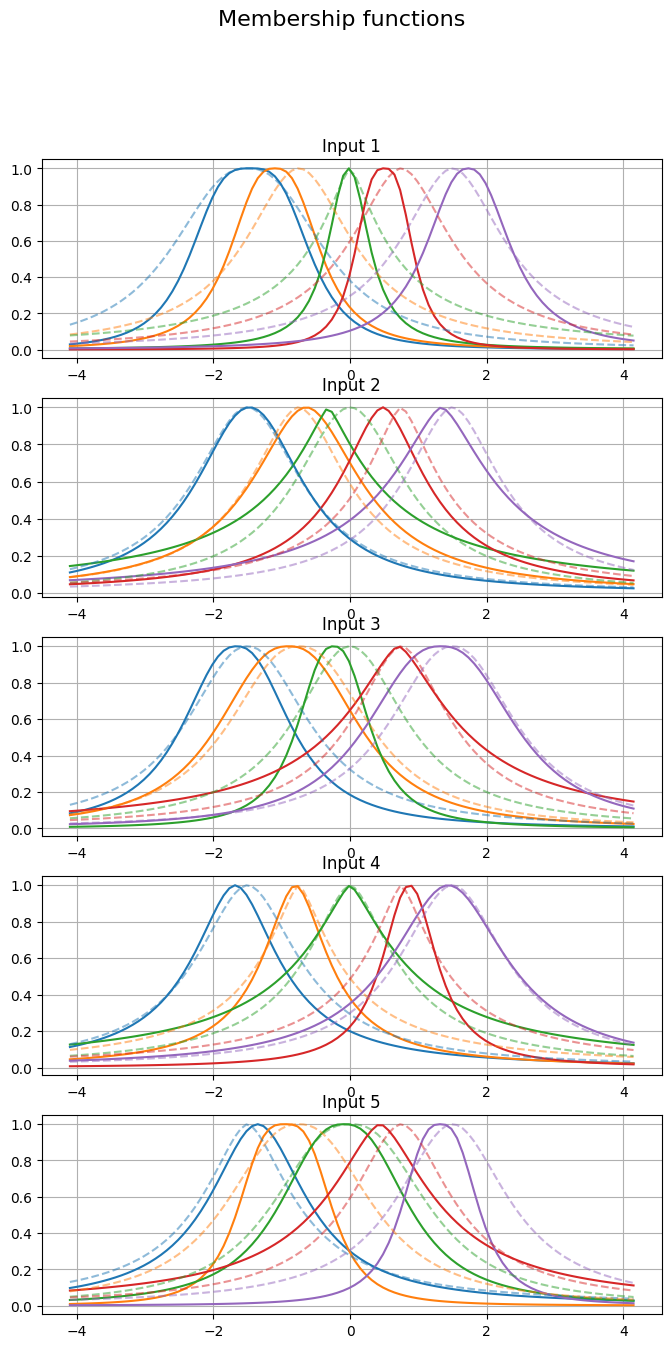

Model: "myanfis"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputLayer (InputLayer)     [(36, 5)]                    0         []                            
                                                                                                  
 fuzzyLayer (FuzzyLayer)     (36, 5, 5)                   75        ['inputLayer[0][0]']          
                                                                                                  
 ruleLayer (RuleLayer)       (36, 3125)                   0         ['fuzzyLayer[0][0]']          
                                                                                                  
 normLayer (NormLayer)       (36, 3125)                   0         ['ruleLayer[0][0]']           
                                                                                            

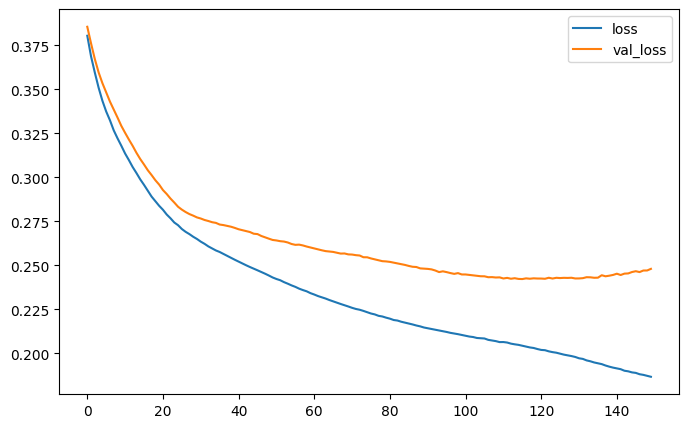

In [959]:
# eval model
fis.plotmfs(show_initial_weights=True)

loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(8, 5))

fis.model.summary()

# get premise parameters
premise_parameters = fis.model.get_layer(
    'fuzzyLayer').get_weights()       # alternative

# get consequence paramters
bias = fis.bias
weights = fis.weights
conseq_parameters = fis.model.get_layer('defuzzLayer').get_weights()       # alternative


In [960]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# Assuming 'y_pred' is the predicted labels and 'y_true' is the true labels
y_pred = fis.__call__(X_test)  # Assuming fis is your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Extract values from confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
sensitivity = recall_score(y_test, y_pred_binary)
specificity = tn / (tn + fp)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')


2/2 [==============================] - 0s 3ms/step
Accuracy: 0.8056
Sensitivity (Recall): 0.5600
Specificity: 0.9362
